In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from qiskit import *
from qiskit import BasicAer
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver, VQE
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization import QuadraticProgram
from qiskit.aqua import QuantumInstance

In [2]:
from qiskit import IBMQ
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

In [3]:
###### Fucntion for creating random adjacency matrix. #########
def create_adjacency_matrix(number_of_vertices, probability):
    adj_matrix = np.ones((number_of_vertices,number_of_vertices))
    for i in range(0,number_of_vertices):
        for j in range(i,number_of_vertices):
            if random.random()>probability or i==j:
                adj_matrix[i,j]=0
                adj_matrix[j,i]=0
    return adj_matrix

In [4]:
##### Function for creating qubo #######
def create_quadratic_program(n,adj_matrix):
    qubo = QuadraticProgram()
    linear_coefficients = list()
    summation_terms = dict()
    for i in range(n):
        qubo.binary_var('x'+ str(i) + 'R')
        linear_coefficients.append(-2)
        qubo.binary_var('x' + str(i) + 'G')
        linear_coefficients.append(-2)
        qubo.binary_var('x' + str(i) + 'B')
        linear_coefficients.append(-2)
    for i in range(n):
        for j in ['R','G','B']:
            summation_terms['x'+str(i)+j,'x'+str(i)+j] = summation_terms.get(('x'+str(i)+j,'x'+str(i)+j), 1)
        summation_terms['x'+str(i)+'R','x'+str(i)+'G'] = summation_terms.get(('x'+str(i)+'R','x'+str(i)+'G'), 1)
        summation_terms['x'+str(i)+'G','x'+str(i)+'B'] = summation_terms.get(('x'+str(i)+'G','x'+str(i)+'B'), 1)
        summation_terms['x'+str(i)+'R','x'+str(i)+'B'] = summation_terms.get(('x'+str(i)+'R','x'+str(i)+'B'), 1)
    for i in range(n-1):
        for j in range(i+1,n):
            if adj_matrix[i,j]==1:
                summation_terms['x'+str(i)+'R','x'+str(j)+'R'] = summation_terms.get(('x'+str(i)+'R','x'+str(j)+'R'), 1)
                summation_terms['x'+str(i)+'G','x'+str(j)+'G'] = summation_terms.get(('x'+str(i)+'G','x'+str(j)+'G'), 1)
                summation_terms['x'+str(i)+'B','x'+str(j)+'B'] = summation_terms.get(('x'+str(i)+'B','x'+str(j)+'B'), 1)
    qubo.minimize(constant = n, linear= linear_coefficients, quadratic= summation_terms)
    #print(qubo.export_as_lp_string())
    return qubo
#matrix = np.array([[0,1,1,1,1],[1,0,1,0,0],[1,1,0,1,0],[1,0,1,0,1],[1,0,0,1,0]])
create_quadratic_program(5,create_adjacency_matrix(5,0.5))

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 2 x0R - 2 x0G - 2 x0B - 2 x1R - 2 x1G - 2 x1B - 2 x2R - 2 x2G - 2 x2B
      - 2 x3R - 2 x3G - 2 x3B - 2 x4R - 2 x4G - 2 x4B + [ 2 x0R^2 + 2 x0R*x0G
      + 2 x0R*x0B + 2 x0R*x1R + 2 x0R*x2R + 2 x0R*x3R + 2 x0G^2 + 2 x0G*x0B
      + 2 x0G*x1G + 2 x0G*x2G + 2 x0G*x3G + 2 x0B^2 + 2 x0B*x1B + 2 x0B*x2B
      + 2 x0B*x3B + 2 x1R^2 + 2 x1R*x1G + 2 x1R*x1B + 2 x1R*x2R + 2 x1G^2
      + 2 x1G*x1B + 2 x1G*x2G + 2 x1B^2 + 2 x1B*x2B + 2 x2R^2 + 2 x2R*x2G
      + 2 x2R*x2B + 2 x2R*x3R + 2 x2G^2 + 2 x2G*x2B + 2 x2G*x3G + 2 x2B^2
      + 2 x2B*x3B + 2 x3R^2 + 2 x3R*x3G + 2 x3R*x3B + 2 x3R*x4R + 2 x3G^2
      + 2 x3G*x3B + 2 x3G*x4G + 2 x3B^2 + 2 x3B*x4B + 2 x4R^2 + 2 x4R*x4G
      + 2 x4R*x4B + 2 x4G^2 + 2 x4G*x4B + 2 x4B^2 ]/2 + 5
Subject To

Bounds
 0 <= x0R <= 1
 0 <= x0G <= 1
 0 <= x0B <= 1
 0 <= x1R <= 1
 0 <= x1G <= 1
 0 <= x1B <= 1
 0 <= x2R <= 1
 0 <= x2G <= 1
 0 <= x2B <= 1
 0 <= x3R <= 1


In [5]:
### Solving using numpyminimumeigensolver ###
def result_exact(qubo):
    exact_mes = NumPyMinimumEigensolver()
    exact = MinimumEigenOptimizer(exact_mes)
    exact_result = exact.solve(qubo)
    return exact_result.fval
qubo = create_quadratic_program(5,create_adjacency_matrix(5,0.5))
#result_exact(qubo)

In [6]:
#### Solving using QAOA
def result_qaoa(qubo):
    qaoa_mes = QAOA(quantum_instance=BasicAer.get_backend('qasm_simulator'))
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    qaoa_result = qaoa.solve(qubo)
    return qaoa_result.fval
qubo = create_quadratic_program(6,create_adjacency_matrix(6,0.5))
#result_qaoa(qubo)

In [7]:
##### solving using VQE

def using_vqe(qubo):
    vqe = VQE(quantum_instance=BasicAer.get_backend('qasm_simulator'))
    vqe_optimizer = MinimumEigenOptimizer(vqe)
    result = vqe_optimizer.solve(qubo)
    return result.fval
qubo = create_quadratic_program(4,create_adjacency_matrix(4,0.5))
#using_vqe(qubo)

In [8]:
#### function for decimal to ternary
def dec_to_tern(k,n):
    ternary = np.zeros((n))
    for i in range(n-1,-1,-1):
        #print(decimal, i)
        if int(k/(3**i)):
            ternary[i]= int(k/(3**i))
        k = k%(3**i)
    return ternary[::-1]
#dec_to_tern(87,6)

In [9]:
### brute force algorithm
def brute_force(n, adj_matrix):
    best_case = None
    cost = 0
    for k in range(3**n):
        test_case = dec_to_tern(k, n)
        temp = 0
        for i in range(n-1):
            for j in range(i+1,n):
                if test_case[i]==test_case[j] and adj_matrix[i,j]==1:
                    temp = temp + 1
        if temp==0:
            break
    return 0
#brute_force(4,create_adjacency_matrix(4,0.5))

0

In [10]:
def main_function(n1,n2):
    cost_vs_n = list()
    time_vs_n = list()
    cost_brute = list()
    cost_numpy = list()
    cost_qaoa = list()
    cost_vqe = list()
    time_numpy = list()
    time_brute = list()
    print( "n & brute_force & Numpysolver & QAOA & VQE")
    for i in range(n1,n2):
        for j in range(5):
            adj_matrix = create_adjacency_matrix(i,0.5)
            qubo = create_quadratic_program(i, adj_matrix)

            initial_time = time.time()
            cost_brute.append(brute_force(i, adj_matrix))
            final_time = time.time()
            time_brute.append(final_time - initial_time)

            initial_time = time.time()
            cost_numpy.append(result_exact(qubo))
            final_time = time.time()
            time_numpy.append(final_time - initial_time)

            cost_qaoa.append(result_qaoa(qubo))
            
            cost_vqe.append(using_vqe(qubo))

        (n, cb, cn, cq, cv) = (i,cost_brute.count(0), cost_numpy.count(0), cost_qaoa.count(0), cost_vqe.count(0))
        (n, tb, tn) = (i, sum(time_brute)/5.0, sum(time_numpy)/5.0)

        print(n,'&', cb, '&', tb, '&', cn, '&', tn, '&', cq, '&' '&', cv, '&')    

        cost_vs_n.append((n, cb, cn, cq, cv))
        time_vs_n.append((n, tn, tb))

        cost_numpy.clear()
        cost_qaoa.clear()
        cost_vqe.clear()
        time_numpy.clear()
        cost_brute.clear()
        time_brute.clear()

    return cost_vs_n, time_vs_n

In [11]:
cost_vs_n, time_vs_n = main_function(4, 7)

In [25]:
cost_vs_n = [(4, 5, 5, 5, 5), (5, 5, 5, 4, 4), (6, 5, 4, 2, 1)]
time_vs_n = [(4, 0.00053672599792480, 0.04169468879699707), (5, 0.0006069660186767579, 0.13005437850952148), (6, 0.0057885169982910155, 1.1360928058624267)]

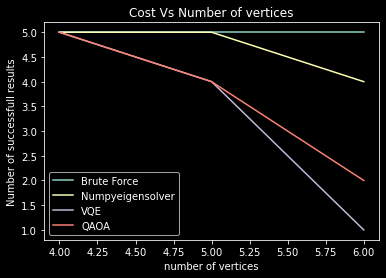

In [26]:
#### plotting cost vs n #####
plt.title("Cost Vs Number of vertices")
plt.ylabel('Number of successfull results')
plt.xlabel('number of vertices')
n, cb, cn, cq, cv = zip(*cost_vs_n)
plt.plot(n, cb, label = 'Brute Force')
plt.plot(n, cn, label = 'Numpyeigensolver')
plt.plot(n, cv, label = 'VQE')
plt.plot(n, cq, label = 'QAOA')
plt.legend()

In [16]:
time_vs_n_qaoa = list([(4, 0.05), (5, 0.17), (6, 0.277)])

In [25]:
#time_vs_n_qaoa.append((6, 0.277))
time_vs_n_qaoa

[(4, 0.05), (5, 0.17), (6, 0.277)]

In [22]:
time_vs_n_vqe = list([(4, 0.728), (5, 1.435), (6, 1.925)])

In [24]:
#time_vs_n_vqe.append((6, 1.925))
time_vs_n_vqe

[(4, 0.728), (5, 1.435), (6, 1.925)]

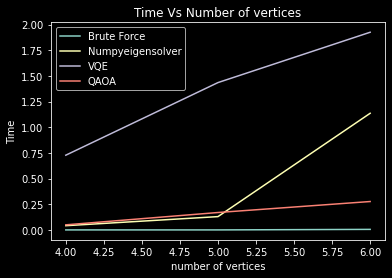

In [23]:
######### Plotting Time Vs n ########
plt.title("Time Vs Number of vertices")
plt.ylabel('Time')
plt.xlabel('number of vertices')
n, tb, tn = zip(*time_vs_n)
plt.plot(n, tb, label = 'Brute Force')
plt.plot(n, tn, label = 'Numpyeigensolver')
n, tv = zip(*time_vs_n_vqe)
plt.plot(n, tv, label = 'VQE')
n, tq = zip(*time_vs_n_qaoa)
plt.plot(n, tq, label = 'QAOA')
plt.legend()

In [14]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.1',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.0'}

In [27]:
from platform import python_version
python_version()

'3.8.6'

In [ ]:
## Code by Chitresh Bhaskar Chaudhari 
## github.com/chit38